# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import csv
from sklearn.model_selection import train_test_split
import random
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pickled data
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
# Let's see what each label refers to
labels_file = './signnames.csv'
with open(labels_file, 'r') as f:
    reader = csv.reader(f)
    #labels_dict = dict(reader)
    labels_list = list(reader)
    
row_format ="{:8} {:s}"
print(row_format.format(*labels_list[0]))
print("-" * 40)
row_format ="{:8} {:s}"
for line in labels_list[1:]:
    print(row_format.format(*line))
labels_dict = dict(labels_list[1:])

ClassId  SignName
----------------------------------------
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)
5        Speed limit (80km/h)
6        End of speed limit (80km/h)
7        Speed limit (100km/h)
8        Speed limit (120km/h)
9        No passing
10       No passing for vehicles over 3.5 metric tons
11       Right-of-way at the next intersection
12       Priority road
13       Yield
14       Stop
15       No vehicles
16       Vehicles over 3.5 metric tons prohibited
17       No entry
18       General caution
19       Dangerous curve to the left
20       Dangerous curve to the right
21       Double curve
22       Bumpy road
23       Slippery road
24       Road narrows on the right
25       Road work
26       Traffic signals
27       Pedestrians
28       Children crossing
29       Bicycles crossing
30       Beware of ice/snow
31       Wild animals crossing
32       End of all sp

Min occ:  210
Max occ:  2250
Median occ:  600.0


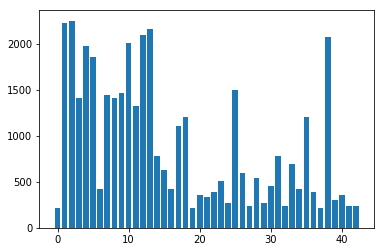

In [5]:
# Is our data balanced? We don't want to have any class over-represented
occurrences = np.bincount(y_train)

print("Min occ: ", min(occurrences))
print("Max occ: ", max(occurrences))
print("Median occ: ", np.median(occurrences))

plt.bar(range(43), occurrences)
plt.show()

## Dealing with unbalanced data

It turns out our training data is very unbalanced (which could create biases towards over-represented classes). We'll tackle this during training by randomly select a balanced subset every epoch.

In [6]:
def balanced_subsample(x, y, subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = int(min_elems * subsample_size)
        
    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(len(x_), dtype=int)
        y_.fill(ci)
        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

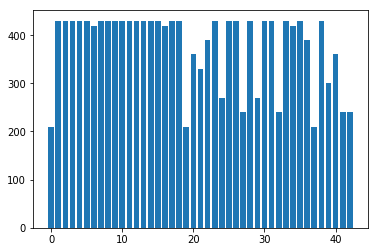

In [7]:
# Just testing if our subsampling works (it does)
X_balanced, y_balanced = balanced_subsample(X_train, y_train, 2.05)
occurrences = np.bincount(y_balanced)
plt.bar(range(43), occurrences)
plt.show()

## However, we'll end up with too few examples of each label if we simply subsample
Before doing so, we'll augment the data set by introducing random image variations to it

## Let's first cut a chunk of data to be our validation set

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Training set size = ", len(X_train))
print("Validation set size = ", len(X_validation))
print("Test set size = ", len(X_test))

Training set size =  31367
Validation set size =  7842
Test set size =  12630


## Let's take a look at our images and get a feel for what they look like

img shape =  (32, 32, 3)
10 : No passing for vehicles over 3.5 metric tons


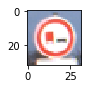

In [9]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
print("img shape = ", image.shape)

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print("{:d} : {:s}".format(y_train[index], labels_dict[str(y_train[index])]))

## Augmenting data

After looking at the winning model for the Traffic Sign Classifier challenge (people.idsia.ch/~juergen/nn2012traffic.pdf) and other techniques for increasing model robustness (mainly this one http://florianmuellerklein.github.io/cnn_streetview/), I decided to create 3 other training datasets in order to create an ensemble of NNs. 

For increasing model robustness I'll rely on dropouts (but we could use the same method being applied here to augment the data set to randomly modify training batches).

For the ensemble implementation, many thanks to https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/05_Ensemble_Learning.ipynb

[[40 41 37]
 [54 51 44]
 [59 54 48]
 [63 60 55]
 [58 58 55]]
uint8
[[ 0.18845168  0.18334784  0.1608925 ]
 [ 0.22224602  0.2062888   0.18093407]
 [ 0.23911725  0.22338176  0.20178853]
 [ 0.23817839  0.23174194  0.21568628]
 [ 0.21129099  0.21937098  0.20599027]]
float32


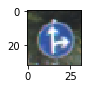

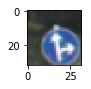

In [10]:
from skimage import transform, filters, exposure

def random_modify_image(image):
    ''' 
    The idea here is to introduce random distortion to image batches
    in order to make the model more robust and less biased to the training set
    This is heavily inspired by Florian Muellerklein street signs recognition. More details
    on his site: http://florianmuellerklein.github.io/cnn_streetview/
    Output are numpy arrays where pixel are in range [0, 1]
    '''
    PIXELS = image.shape[0]
    # random rotations betweein -5 and 5 degrees
    dorotate = random.randint(-5,5)

    # random translations
    trans_1 = random.randint(-5,5)
    trans_2 = random.randint(-5,5)

    # random zooms
    zoom = random.uniform(0.95, 1.05)
    
    # shearing
    shear_deg = random.uniform(-10, 10)

    # set the transform parameters for skimage.transform.warp
    # have to shift to center and then shift back after transformation otherwise
    # rotations will make image go out of frame
    center_shift   = np.array((PIXELS, PIXELS)) / 2. - 0.5
    tform_center   = transform.SimilarityTransform(translation=-center_shift)
    tform_uncenter = transform.SimilarityTransform(translation=center_shift)

    tform_aug = transform.AffineTransform(rotation = np.deg2rad(dorotate),
                                          scale =(1/zoom, 1/zoom),
                                          shear = np.deg2rad(shear_deg),
                                          translation = (trans_1, trans_2))

    tform = tform_center + tform_aug + tform_uncenter

    return np.array(transform.warp(image, \
                          tform.params, \
                          output_shape=(PIXELS, PIXELS), 
                          mode='edge', \
                          preserve_range=False), dtype=np.float32)

def random_modify_batch(batch):
    return np.array([random_modify_image(img) for img in batch])

# DEBUG
images = X_train[0:1]
new_batch = random_modify_batch(images)
for i in range(len(new_batch)):
    plt.figure(figsize=(1,1))
    plt.imshow(X_train[i], cmap="gray")
    print(X_train[i][0][0:5])
    print(X_train[i].dtype)
    plt.figure(figsize=(1,1))
    plt.imshow(new_batch[i], cmap="gray")
    print(new_batch[i][0][0:5])
    print(new_batch[i].dtype)

In [11]:
# Augmenting the training set 5-fold
BATCH_SIZE = 128
NUM_ITERS = 5
num_examples = len(X_train)

print("original training count = ", X_train.shape)

X_train_norm = np.array(X_train / 255., dtype=np.float32)

original training count =  (31367, 32, 32, 3)


In [12]:
X_train_aug = X_train_norm
y_train_aug = y_train

for i in range(NUM_ITERS - 1):
    print("Iter {}".format(i))
    print("Augmented training count = ", X_train_aug.shape)
    X_batch = []
    y_batch = []
    for offset in range(num_examples):
        X_batch.append(random_modify_image(X_train_norm[offset]))
        y_batch.append(y_train[offset])
    X_train_aug = np.append(X_train_aug, np.array(X_batch), axis=0)
    y_train_aug = np.append(y_train_aug, np.array(y_batch), axis=0)

print("Final augmented training count = {}, dtype = {}".format(X_train_aug.shape, X_train_aug.dtype))

Iter 0
Augmented training count =  (31367, 32, 32, 3)
Iter 1
Augmented training count =  (62734, 32, 32, 3)
Iter 2
Augmented training count =  (94101, 32, 32, 3)
Iter 3
Augmented training count =  (125468, 32, 32, 3)
Final augmented training count = (156835, 32, 32, 3), dtype = float32


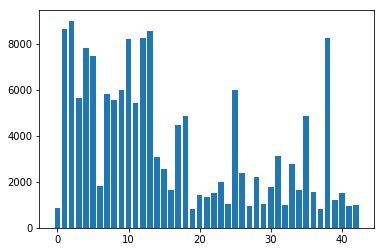

0.0
1.0


In [13]:
# Looks correct?
occurrences = np.bincount(y_train_aug)
plt.bar(range(43), occurrences)
plt.show()

print(np.min(X_train_aug))
print(np.max(X_train_aug))

In [14]:
# Creating aditional training sets with different image equalization ideas
def rescale_intensity(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

def adapteq(img):
    tmp = np.array(img * 255, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(3,3))
    img_yuv = cv2.cvtColor(tmp, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_adapteq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return normalize(img_adapteq)
    
def equalize(img):
    tmp = np.array(img * 255, dtype=np.uint8)
    img_yuv = cv2.cvtColor(tmp, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return normalize(img_eq)

def normalize(img):
    return np.array(img / 255., dtype=np.float32)

In [15]:
# Different subsamples for each network (not fully balanced to get enough samples, but much more balanced than before)
X_orig, y_orig = balanced_subsample(X_train_aug, y_train_aug, 3)
X_eq, y_eq = balanced_subsample(X_train_aug, y_train_aug, 3)
X_adapteq, y_adapteq = balanced_subsample(X_train_aug, y_train_aug, 3)
X_rescale, y_rescale = balanced_subsample(X_train_aug, y_train_aug, 3)

In [16]:
# Normalizing data and equalizing
X_train_dict = {0: X_orig,
                1: np.array([equalize(img) for img in X_eq]),
                2: np.array([adapteq(img) for img in X_adapteq]),
                3: np.array([rescale_intensity(img) for img in X_rescale])}
y_train_dict = {0: y_orig,
                1: y_eq,
                2: y_adapteq,
                3: y_rescale}

X_validation = np.array([normalize(img) for img in X_validation], dtype=np.float32)
X_valid_dict = {0: X_validation,
                1: np.array([equalize(img) for img in X_validation]),
                2: np.array([adapteq(img) for img in X_validation]),
                3: np.array([rescale_intensity(img) for img in X_validation])}
y_valid_dict = {0: y_validation,
                1: y_validation,
                2: y_validation,
                3: y_validation}

X_test = np.array([normalize(img) for img in X_test], dtype=np.float32)
X_test_dict = {0: X_test,
               1: np.array([equalize(img) for img in X_test]),
               2: np.array([adapteq(img) for img in X_test]),
               3: np.array([rescale_intensity(img) for img in X_test])}
y_test_dict = {0: y_test,
               1: y_test,
               2: y_test,
               3: y_test}

# Store data
with open('x_valid_dict.pickle', 'wb') as handle:
    pickle.dump(X_valid_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_valid_dict.pickle', 'wb') as handle:
    pickle.dump(y_valid_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_test_dict.pickle', 'wb') as handle:
    pickle.dump(X_test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test_dict.pickle', 'wb') as handle:
    pickle.dump(y_test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Checking all sets are correct
for i in sorted(X_train_dict.keys()):
    print("min = {:.4f}, max = {:.4f}, shape = {}".format(np.min(X_train_dict[i]), \
                                                          np.max(X_train_dict[i]), \
                                                          X_train_dict[i].shape))
for i in sorted(X_valid_dict.keys()):
    print("min = {:.4f}, max = {:.4f}, shape = {}".format(np.min(X_valid_dict[i]), \
                                                          np.max(X_valid_dict[i]), \
                                                          X_valid_dict[i].shape))
for i in sorted(X_test_dict.keys()):
    print("min = {:.4f}, max = {:.4f}, shape = {}".format(np.min(X_test_dict[i]), \
                                                          np.max(X_test_dict[i]), \
                                                          X_test_dict[i].shape))

min = 0.0000, max = 1.0000, shape = (81900, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (81900, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (81900, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (81900, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (7842, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (7842, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (7842, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (7842, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (12630, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (12630, 32, 32, 3)
min = 0.0235, max = 1.0000, shape = (12630, 32, 32, 3)
min = 0.0000, max = 1.0000, shape = (12630, 32, 32, 3)


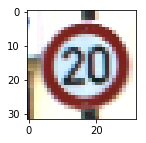

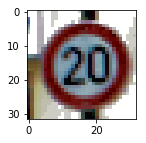

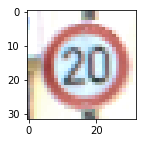

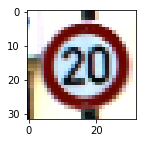

In [18]:
# Let's take a look at the resulting images
for i in sorted(X_train_dict.keys()):
    plt.figure(figsize=(2,2))
    plt.imshow(X_train_dict[i][0], cmap="gray")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
import tensorflow as tf

In [20]:
from tensorflow.contrib.layers import flatten

def TrafficNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x48
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 48), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(48))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x48. Output = 14x14x48.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x96.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 48, 96), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(96))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x96. Output = 5x5x96.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x96. Output = 2400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 2400. Output = 800. Dropout.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2400, 800), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 800. Output = 240. Dropout.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800, 240), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(240))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 240. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(240, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [22]:
rate = 0.001

logits = TrafficNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = session.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
import os
saver = tf.train.Saver(max_to_keep=100)
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

In [25]:
from sklearn.utils import shuffle

session = tf.Session()
EPOCHS = 20
BATCH_SIZE = 64

In [26]:
for i in sorted(X_train_dict.keys()):
    print("Neural network: {0}".format(i))
    session.run(tf.global_variables_initializer())
    num_examples = len(X_train_dict[i])
    for j in range(EPOCHS):
        X_epoch, y_epoch = shuffle(X_train_dict[i], y_train_dict[i])
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_epoch[offset:end], y_epoch[offset:end]
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        validation_accuracy = evaluate(X_valid_dict[i], y_valid_dict[i])
        msg = "Epoch: {0}, Accuracy on Validation-Set: {1:.4f}"
        print(msg.format(j, validation_accuracy))
        if validation_accuracy > 0.995:
            break
    saver.save(sess=session, save_path=get_save_path(i))
    print("Saved.")
    print()

Neural network: 0
Epoch: 0, Accuracy on Validation-Set: 0.9063
Epoch: 1, Accuracy on Validation-Set: 0.9832
Epoch: 2, Accuracy on Validation-Set: 0.9869
Epoch: 3, Accuracy on Validation-Set: 0.9925
Epoch: 4, Accuracy on Validation-Set: 0.9903
Epoch: 5, Accuracy on Validation-Set: 0.9872
Epoch: 6, Accuracy on Validation-Set: 0.9906
Epoch: 7, Accuracy on Validation-Set: 0.9930
Epoch: 8, Accuracy on Validation-Set: 0.9936
Epoch: 9, Accuracy on Validation-Set: 0.9958
Saved.

Neural network: 1
Epoch: 0, Accuracy on Validation-Set: 0.8157
Epoch: 1, Accuracy on Validation-Set: 0.9267
Epoch: 2, Accuracy on Validation-Set: 0.9631
Epoch: 3, Accuracy on Validation-Set: 0.9742
Epoch: 4, Accuracy on Validation-Set: 0.9779
Epoch: 5, Accuracy on Validation-Set: 0.9852
Epoch: 6, Accuracy on Validation-Set: 0.9816
Epoch: 7, Accuracy on Validation-Set: 0.9892
Epoch: 8, Accuracy on Validation-Set: 0.9833
Epoch: 9, Accuracy on Validation-Set: 0.9860
Epoch: 10, Accuracy on Validation-Set: 0.9881
Epoch: 11,

In [27]:
# Load data
with open('x_valid_dict.pickle', 'rb') as handle:
    X_valid_dict = pickle.load(handle)
with open('y_valid_dict.pickle', 'rb') as handle:
    y_valid_dict = pickle.load(handle)
with open('x_test_dict.pickle', 'rb') as handle:
    X_test_dict = pickle.load(handle)
with open('y_test_dict.pickle', 'rb') as handle:
    y_test_dict = pickle.load(handle)

In [28]:
def softmax_predictions(X_data, y_data):
    num_examples = len(X_data)
    pred_labels = np.zeros(shape=(num_examples, 43), dtype=np.float)
    probabilites = tf.nn.softmax(logits)
    
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        pred_labels[offset:end] = session.run(probabilites, feed_dict={x: X_data[offset:end], 
                                                                       y: y_data[offset:end], 
                                                                       keep_prob: 1.0})

    return pred_labels

In [29]:
def ensemble_predictions():
    # Empty list of predicted labels for each of the neural networks.
    pred_labels = []

    # Classification accuracy on the test-set for each network.
    test_accuracies = []

    # Classification accuracy on the validation-set for each network.
    val_accuracies = []

    # For each neural network in the ensemble.
    for i in sorted(X_test_dict.keys()):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        val_acc = evaluate(X_valid_dict[i], y_valid_dict[i])
        val_accuracies.append(val_acc)
        test_acc = evaluate(X_test_dict[i], y_test_dict[i])
        test_accuracies.append(test_acc)
        msg = "Network: {0}, Accuracy on Validation-Set: {1:.4f}, Test-Set: {2:.4f}"
        print(msg.format(i, val_acc, test_acc))

        pred = softmax_predictions(X_test_dict[i], y_test_dict[i])
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies), \
           np.array(val_accuracies)

In [49]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

Network: 0, Accuracy on Validation-Set: 0.9958, Test-Set: 0.9613
Network: 1, Accuracy on Validation-Set: 0.9862, Test-Set: 0.9523
Network: 2, Accuracy on Validation-Set: 0.9955, Test-Set: 0.9644
Network: 3, Accuracy on Validation-Set: 0.9955, Test-Set: 0.9622


## Now let's use the different networks predicted labels to get more robust predictions
We'll average the probabilities for each label for each test image

In [50]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(12630, 43)

In [51]:
ensemble_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_pred.shape

(12630,)

In [52]:
ensemble_correct = (ensemble_pred == y_test_dict[0])
ensemble_acc = np.sum(ensemble_correct) / len(y_test_dict[0])

In [58]:
for i in range(5):
    print("Image {} top 3 predictions".format(i))
    top_3 = (-ensemble_pred_labels[i]).argsort()[:3]
    for label in top_3:
        print("-> Label = {} : {}, certainty = {:.3f}".format(label, \
                                                              labels_dict[str(label)], \
                                                              ensemble_pred_labels[i][label]))

Image 0 top 3 predictions
-> Label = 16 : Vehicles over 3.5 metric tons prohibited, certainty = 1.000
-> Label = 34 : Turn left ahead, certainty = 0.000
-> Label = 9 : No passing, certainty = 0.000
Image 1 top 3 predictions
-> Label = 1 : Speed limit (30km/h), certainty = 1.000
-> Label = 2 : Speed limit (50km/h), certainty = 0.000
-> Label = 4 : Speed limit (70km/h), certainty = 0.000
Image 2 top 3 predictions
-> Label = 38 : Keep right, certainty = 1.000
-> Label = 34 : Turn left ahead, certainty = 0.000
-> Label = 0 : Speed limit (20km/h), certainty = 0.000
Image 3 top 3 predictions
-> Label = 33 : Turn right ahead, certainty = 1.000
-> Label = 42 : End of no passing by vehicles over 3.5 metric tons, certainty = 0.000
-> Label = 37 : Go straight or left, certainty = 0.000
Image 4 top 3 predictions
-> Label = 11 : Right-of-way at the next intersection, certainty = 1.000
-> Label = 30 : Beware of ice/snow, certainty = 0.000
-> Label = 20 : Dangerous curve to the right, certainty = 0.0

In [72]:
wrong_predictions = list(np.where(ensemble_correct == 0))
for i in wrong_predictions[0][0:5]:
    print("Image {} top 3 predictions".format(i))
    top_3 = (-ensemble_pred_labels[i]).argsort()[:3]
    print("-> Correct label = {} : {}".format(y_test_dict[0][i], \
                                              labels_dict[str(y_test_dict[0][i])]))
    for label in top_3:
        print("-> Label = {} : {}, certainty = {:.3f}".format(label, \
                                                              labels_dict[str(label)], \
                                                              ensemble_pred_labels[i][label]))

Image 50 top 3 predictions
-> Correct label = 25 : Road work
-> Label = 18 : General caution, certainty = 0.231
-> Label = 25 : Road work, certainty = 0.147
-> Label = 26 : Traffic signals, certainty = 0.127
Image 83 top 3 predictions
-> Correct label = 7 : Speed limit (100km/h)
-> Label = 8 : Speed limit (120km/h), certainty = 0.500
-> Label = 7 : Speed limit (100km/h), certainty = 0.491
-> Label = 5 : Speed limit (80km/h), certainty = 0.008
Image 114 top 3 predictions
-> Correct label = 30 : Beware of ice/snow
-> Label = 23 : Slippery road, certainty = 0.553
-> Label = 30 : Beware of ice/snow, certainty = 0.139
-> Label = 20 : Dangerous curve to the right, certainty = 0.106
Image 127 top 3 predictions
-> Correct label = 30 : Beware of ice/snow
-> Label = 20 : Dangerous curve to the right, certainty = 0.478
-> Label = 18 : General caution, certainty = 0.249
-> Label = 31 : Wild animals crossing, certainty = 0.068
Image 131 top 3 predictions
-> Correct label = 3 : Speed limit (60km/h)


In [73]:
print("Ensemble accuracy on Test-Set: {:.4f}".format(ensemble_acc))

Ensemble accuracy on Test-Set: 0.9841


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I cut 20% of the training set to serve as validation (we could have used cross-validation instead but I felt there was no need for it in this particular example). Other than that, images were normalized to be in the range of [0, 1] instead of [0, 255]. Using color images are the obvious choice here since traffic signs convey information not only through shapes but also through colors. I also wanted to have models that were robust to different light conditions: creating models that use different types of image equalization do help with model generalizations. 
This is also backed by the winner paper in the traffic sign classifier challenge (people.idsia.ch/~juergen/nn2012traffic.pdf)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Looking at the training set, we can see that data is extremely unbalanced. The number of examples per sign varies from ~200 examples to ~2000 (a inbalance of 10x). I wanted to subsample my training data so that labels were more balanced but didn't want to end up with too few images. Also, I wanted my models to be more robust to variation. To achieve these two goals, I created extra images with random rotation/translation/shearing (ending with a training set 5x bigger the oiginal). I then used this augmented data set to create subsamples with a maximum unbalance of 3x.
Another option for robustness would be to introduce variation in the images during training. This however, makes the training much slower and a few tests showed no significant increase in accuracy.

I also wanted to use an ensemble of NNs to increase prediction accuracy. So, I created three other data-sets to serve as input for other NNs. In the end, I used an ensemble of 4 models (original, equalization, adaptive equalization, intensity rescaling).

In [74]:
### Define your architecture here.
# Please refer to TrafficNet() up in the notebook

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I'm using an ensemble of 4 NNs (using the original, equalized, adpative equalized and intensity rescaled images). Each of the networks is modeled as follows:

1. Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x48 (5x5 filter, stride 1)
2. Max Pooling: Input = 28x28x48. Output = 14x14x48.
3. Layer 2: Convolutional. Input = 14x14x48 Output = 10x10x96. (5x5 filter, stride 1)
4. Max Pooling. Input = 10x10x96. Output = 5x5x96.
5. Flatten. Input = 5x5x96. Output = 2400.
6. Layer 3: Fully Connected. Input = 2400. Output = 800 + 50% Dropout.
7. Layer 4: Fully Connected. Input = 800. Output = 240 + 50% Dropout.
8. Layer 5: Fully Connected. Input = 240. Output = 43.

The softmax output of the 4 networks is then averaged to get our final prediction

In [75]:
### Train your model here.
### Feel free to use as many code cells as needed.
# Please refer to training code above in the notebook

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I'm using an Adam Optimizer, learning rate of 0.001, batch size of 64. Different batch sizes didn't produce any significant changes in accuracy. Higher learning rates produced worst results, smaller rates took too long to converge.

I've limited my training to 20 epochs and added an accuracy cut-off to avoid overfitting. For the weights initialization, I used a normal distribution centered in zero with 0.1 standard deviation. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I conducted several experiments:

- Using LeNet as a first approach
- Adding dropout layers
- Augmenting data (and then realizing I needed more neurons to deal with the added complexity)
- Incresing the depth of the filters
- Testing how an extra convolutional layer would affect training
- Using different equalization techniques
- Using random perturbation both as pre-processing and during training
- Subsampling options
- Ensemble of NNs

In the end, I decided to stick to the ensemble approach that won the Traffic Sign Classifier challenge with a few changes (mainly to spare some computing power). I have also adapted the depth of the networks since we're using smaller images (32x32 vs. 48x48). I have also used a different perturbation method than the one described in the Juergen's paper. Since I was not adding random perturbations during training, using dropout felt like a correct approach to increase robustness.

I'm confident that I could boost test accuracy up (I achieved 98.41%) by adding a few extra networks to the ensemble.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

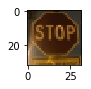

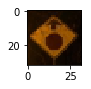

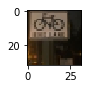

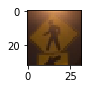

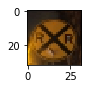

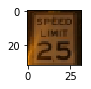

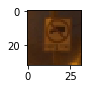

In [76]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

new_images = []
img_path = "./us_signs/"
image_list = os.listdir(img_path)
for img_file in image_list:
    #image = cv2.imread(img_path + img_file, cv2.IMREAD_COLOR)
    image = mpimg.imread(img_path + img_file)
    new_images.append(image)
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Using the first 5 images of the set above, we could see that light conditions are far from ideal (these pictures were taken at night). Another obvious problem is that not all signs are part of the german sign database.

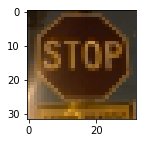

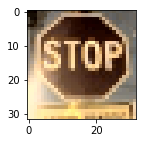

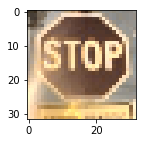

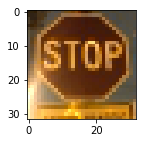

In [77]:
# Pre-processing
X_us_signs = np.array([normalize(img) for img in new_images[0:5]], dtype=np.float32)
X_us_signs = {0: X_us_signs,
              1: np.array([equalize(img) for img in X_us_signs]),
              2: np.array([adapteq(img) for img in X_us_signs]),
              3: np.array([rescale_intensity(img) for img in X_us_signs])}

# Let's take a look at the resulting images
for i in sorted(X_us_signs.keys()):
    plt.figure(figsize=(2,2))
    plt.imshow(X_us_signs[i][0], cmap="gray")

In [78]:
def unlabeled_predictions(X_data):
    pred_labels = []
    # For each neural network in the ensemble.
    for i in sorted(X_data.keys()):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))
        y_data = np.zeros(len(X_data))
        pred = softmax_predictions(X_data[i], y_data)
        pred_labels.append(pred)
    
    return np.array(pred_labels)

In [79]:
pred_labels = unlabeled_predictions(X_us_signs)
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred = np.argmax(ensemble_pred_labels, axis=1)
print(ensemble_pred_labels.shape)
print(ensemble_pred.shape)

(5, 43)
(5,)


In [80]:
for i in range(len(ensemble_pred)):
    print("Image {} top 5 predictions".format(i))
    top_5 = (-ensemble_pred_labels[i]).argsort()[:5]
    for label in top_5:
        print("-> Label = {} : {}, certainty = {:.3f}".format(label, \
                                                              labels_dict[str(label)], \
                                                              ensemble_pred_labels[i][label]))

Image 0 top 5 predictions
-> Label = 14 : Stop, certainty = 0.673
-> Label = 1 : Speed limit (30km/h), certainty = 0.068
-> Label = 2 : Speed limit (50km/h), certainty = 0.066
-> Label = 5 : Speed limit (80km/h), certainty = 0.020
-> Label = 40 : Roundabout mandatory, certainty = 0.020
Image 1 top 5 predictions
-> Label = 12 : Priority road, certainty = 0.410
-> Label = 5 : Speed limit (80km/h), certainty = 0.334
-> Label = 2 : Speed limit (50km/h), certainty = 0.070
-> Label = 13 : Yield, certainty = 0.059
-> Label = 8 : Speed limit (120km/h), certainty = 0.036
Image 2 top 5 predictions
-> Label = 2 : Speed limit (50km/h), certainty = 0.137
-> Label = 8 : Speed limit (120km/h), certainty = 0.104
-> Label = 20 : Dangerous curve to the right, certainty = 0.096
-> Label = 1 : Speed limit (30km/h), certainty = 0.094
-> Label = 26 : Traffic signals, certainty = 0.062
Image 3 top 5 predictions
-> Label = 13 : Yield, certainty = 0.227
-> Label = 26 : Traffic signals, certainty = 0.214
-> Lab

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The accuracy with the test set is reasonably good: 98.41%. Accuracy for the sample US traffic signs was 20%, but that's what I expected. From all signs in the dataset, the only that could be matched to the german traffic signs database was the stop sign and it was correctly predicted (with 67.3% certainty). I believe the trained model could perform well under real world conditions. It would be very interesting to get access to more data that could match the signs in the database and really put this statement to test.

In [81]:
### Visualize the softmax probabilities here.
## Softmax predictions are printed just before question 7

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model is usually very certain when classifying signs from the test set (mind the softmax predictions in section "Now let's use the different networks predicted labels to get more robust predictions"). For the US traffic signs, this is not quite true. For the only correctly predicted sign, certainty is only 67%. However, the second most likely label has a probability of only 6.8%. For traffic signs that could not be predicted (because they're not part of the database), we can see certainty being much lower for the predicted label as expected.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.